In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime

%matplotlib notebook


In [3]:
traffic_2015 = pd.read_csv("./data/dot_traffic_2015.txt.gz")
traffic_2015_stations = pd.read_csv("./data/dot_traffic_stations_2015.txt.gz")

## Peak travel by day of the year

Integrating over all traffic monitoring stations in the country and binning by day should leave only very prominent features, most likely major holidays, for example Christmas and Thanksgiving, when many people travel to see family.

**Expectation: Maximum just before Christmas and Thanksgiving**

In [4]:
days = [(datetime.date(year=2015, month=1, day=1) + datetime.timedelta(days=i)).isoformat() for i in range(365)]
months = [(datetime.date(year=2015, month=i+1, day=1) - (datetime.date(year=2015, month=1, day=1))).days for i in range(12)]

In [5]:
def get_daily_volume_from_points(traffic_data):
    volume = np.zeros(365)
    for i in range(365):
        a = traffic_data[traffic_data["date"] == days[i]]
        b = a.loc[:,"traffic_volume_counted_after_0000_to_0100":"traffic_volume_counted_after_2300_to_2400"]
        volume[i] = np.sum(b.sum().iloc[0:24])
    
    return volume

In [6]:
volume = get_daily_volume_from_points(traffic_2015)

<IPython.core.display.Javascript object>


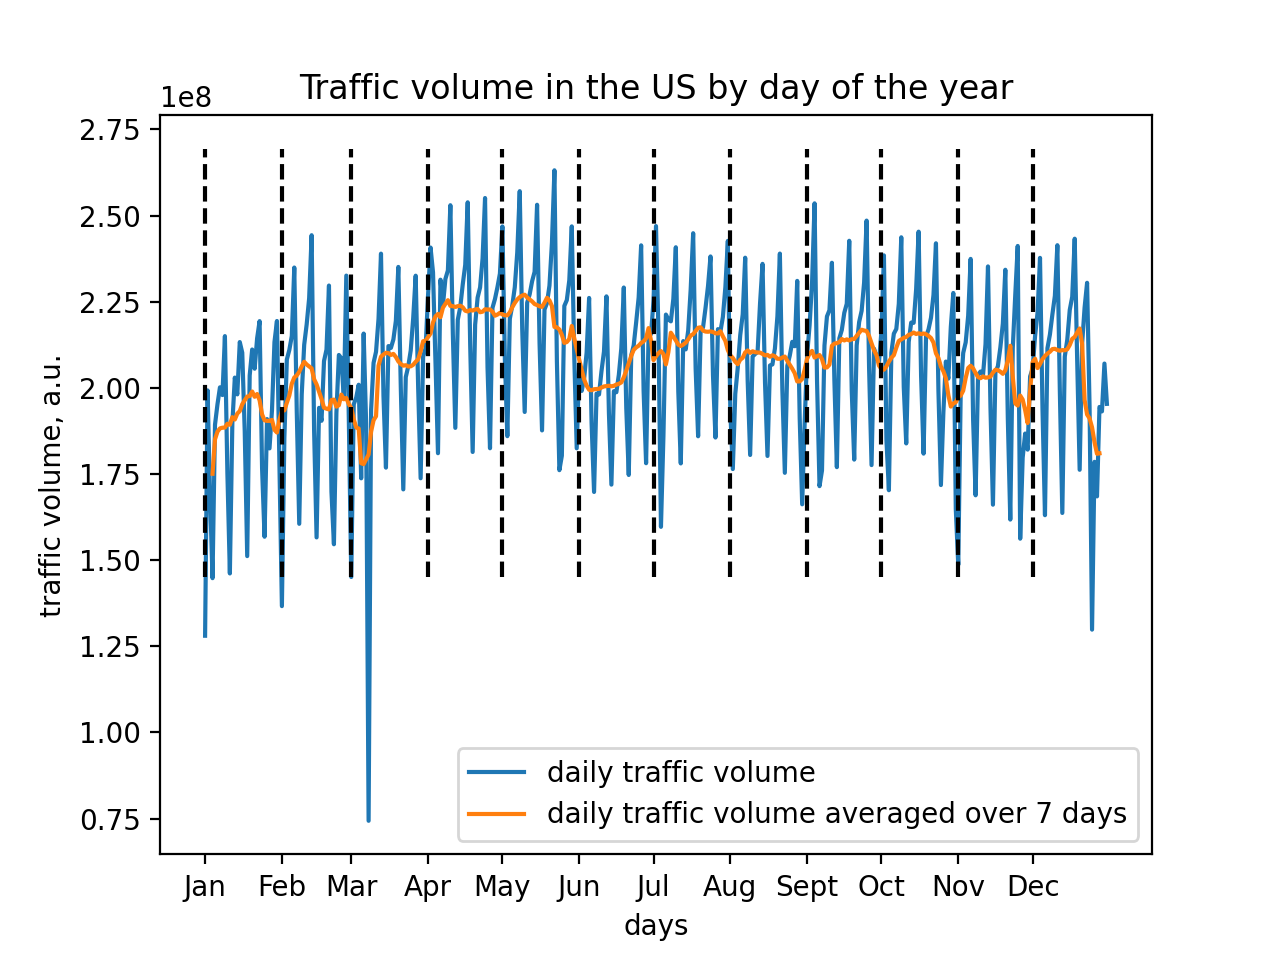

In [15]:
volume_1 = np.convolve(volume, np.ones((7,))/7, mode='valid')
days_1 = np.convolve(range(365), np.ones((7,))/7, mode='valid')
plt.plot(range(365), volume, label="daily traffic volume")
plt.plot(days_1, volume_1, label="daily traffic volume averaged over 7 days")
for i in months:
    plt.plot([i,i], [np.mean(volume)*0.7, np.mean(volume)*1.3], color = "black", linestyle="dashed")

plt.xticks(months, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.xlabel("days")
plt.ylabel("traffic volume, a.u.")
plt.title("Traffic volume in the US by day of the year")
plt.legend(loc="lower right")

## Reality

Small peaks just before Thanksgiving and Christmas, followed by 1-2 week long dips.
Data turned out much noisier when binning by day, with an approximately 7 day long repeating oscillation.
The 7-day oscillation drowns out most other features, so to see them, we need to run a 7-day rolling average filter on the data, to average out the weekly oscillation.

This leaves us with a much smoother plot with several features of note.

1. As expected, November and December have a peak and dip right around Thanksgiving and Christmas
2. Much more pronounced dip in the beginning of March, right at Easter, protentially related to spring break at schools
3. Second dip in June, also potentially related to school - the school year should be ending at about this time



To check #2, I'll look at traffic data around the largest universities in the US, for example UCF in Orlando and Texas A&M at College Station, TX. If the dip in March is related to university students, than the dip should be more pronounced at these locations than in a less spring break affected location, for example New York City.  

In [8]:
def get_points_in_area(lat_north, lat_south, long_west, long_east):
    sd_traffic_2015_stations = traffic_2015_stations[(traffic_2015_stations["longitude"] <= long_west) \
                         & (traffic_2015_stations["longitude"] >= long_east) \
                         & (traffic_2015_stations["latitude"] <= lat_north) \
                         & (traffic_2015_stations["latitude"] >= lat_south)]

    drop_columns = list(sd_traffic_2015_stations.columns.difference(['station_id','latitude','longitude']))
    sd_traffic_2015_stations = sd_traffic_2015_stations.drop(drop_columns, axis = 1)
    station_ids = sorted(sd_traffic_2015_stations["station_id"].unique())

    selected_traffic = traffic_2015[traffic_2015["station_id"].isin(station_ids)]
    
    return selected_traffic

<IPython.core.display.Javascript object>


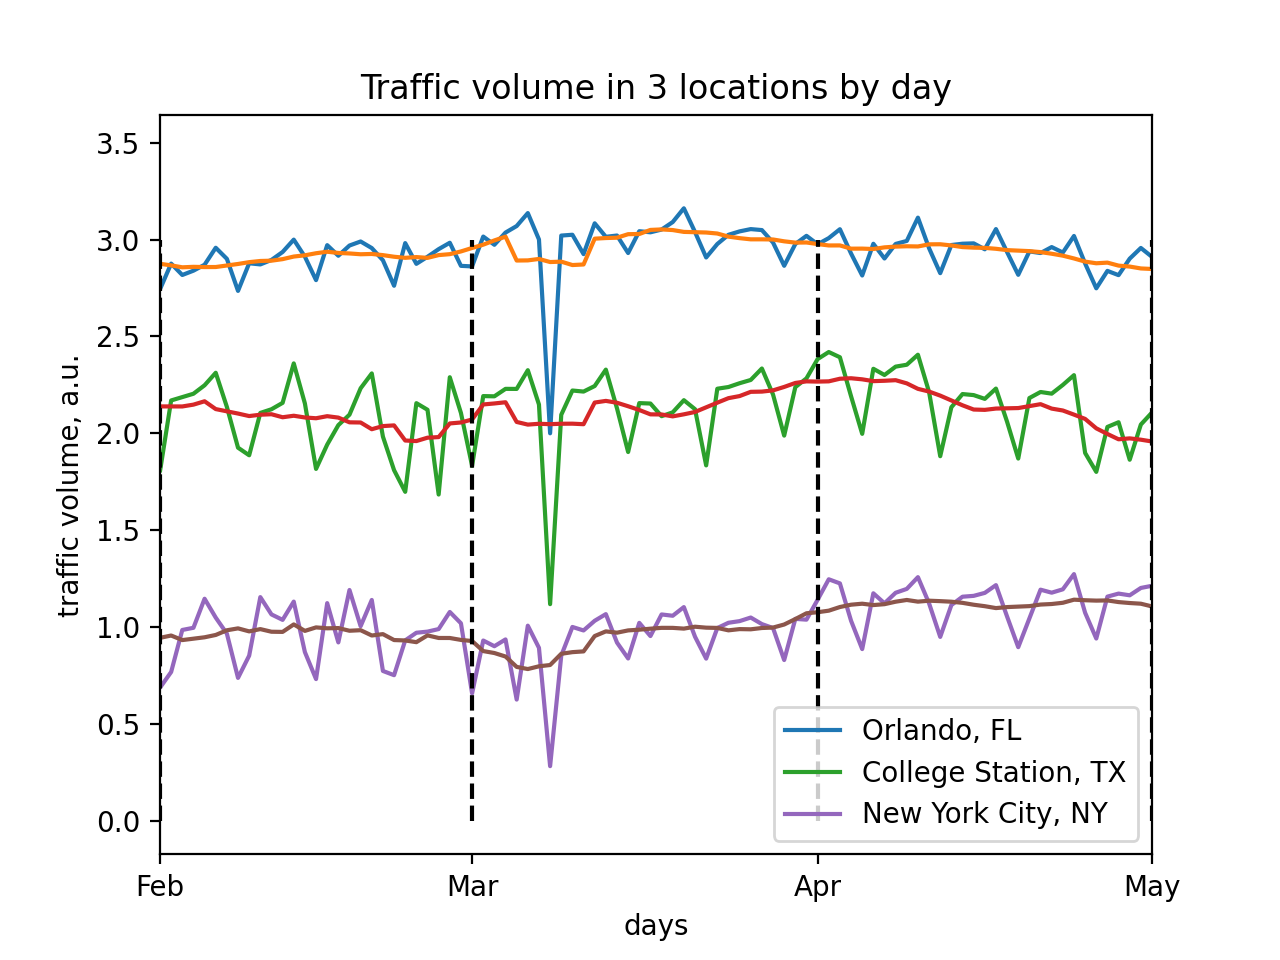

Text(0.5, 1.0, 'Traffic volume in 3 locations by day')

In [11]:
#
# Orlando, FL
#
lat_north = 28.8
lat_south = 27.7
long_west = 81.7 
long_east = 80.7

orlando_traffic_2015 = get_points_in_area(lat_north, lat_south, long_west, long_east)
orlando_volume = get_daily_volume_from_points(orlando_traffic_2015)

orlando_volume_1 = np.convolve(orlando_volume, np.ones((7,))/7, mode='valid')
days_1 = np.convolve(range(365), np.ones((7,))/7, mode='valid')
plt.plot(range(365), orlando_volume/np.mean(orlando_volume)+2, label="Orlando, FL")
plt.plot(days_1, orlando_volume_1/np.mean(orlando_volume_1)+2)

#
# College Station, TX
#
lat_north = 30.8
lat_south = 29.8
long_west = 96 
long_east = 95


collegestation_traffic_2015 = get_points_in_area(lat_north, lat_south, long_west, long_east)
collegestation_volume = get_daily_volume_from_points(collegestation_traffic_2015)
    
collegestation_volume_1 = np.convolve(collegestation_volume, np.ones((7,))/7, mode='valid')
days_1 = np.convolve(range(365), np.ones((7,))/7, mode='valid')
plt.plot(range(365), collegestation_volume/np.mean(collegestation_volume)+1, label="College Station, TX")
plt.plot(days_1, collegestation_volume_1/np.mean(collegestation_volume_1)+1)

#
# New York 
#
lat_north = 41.2
lat_south = 40
long_west = 75 
long_east = 73


ny_traffic_2015 = get_points_in_area(lat_north, lat_south, long_west, long_east)
ny_volume = get_daily_volume_from_points(ny_traffic_2015)
    
ny_volume_1 = np.convolve(ny_volume, np.ones((7,))/7, mode='valid')
days_1 = np.convolve(range(365), np.ones((7,))/7, mode='valid')
plt.plot(range(365), ny_volume/np.mean(ny_volume), label="New York City, NY")
plt.plot(days_1, ny_volume_1/np.mean(ny_volume_1))


for i in months:
    plt.plot([i,i], [0, 3], color = "black", linestyle="dashed")

plt.xticks(months, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.xlim([months[1], months[4]])
plt.xlabel("days")
plt.ylabel("traffic volume, a.u.")
plt.legend(loc="lower right")
plt.title("Traffic volume in 3 locations by day")

Here we can see that the two locations with significant student populations have a more pronounced dip in march than New York, which supports our hypothesis. Further testing could be done trying to find locations with significant march dips and correlating the locations to large college towns.

While looking at the Orlando, FL data, there is a clear increase in traffic starting from September - 

<IPython.core.display.Javascript object>


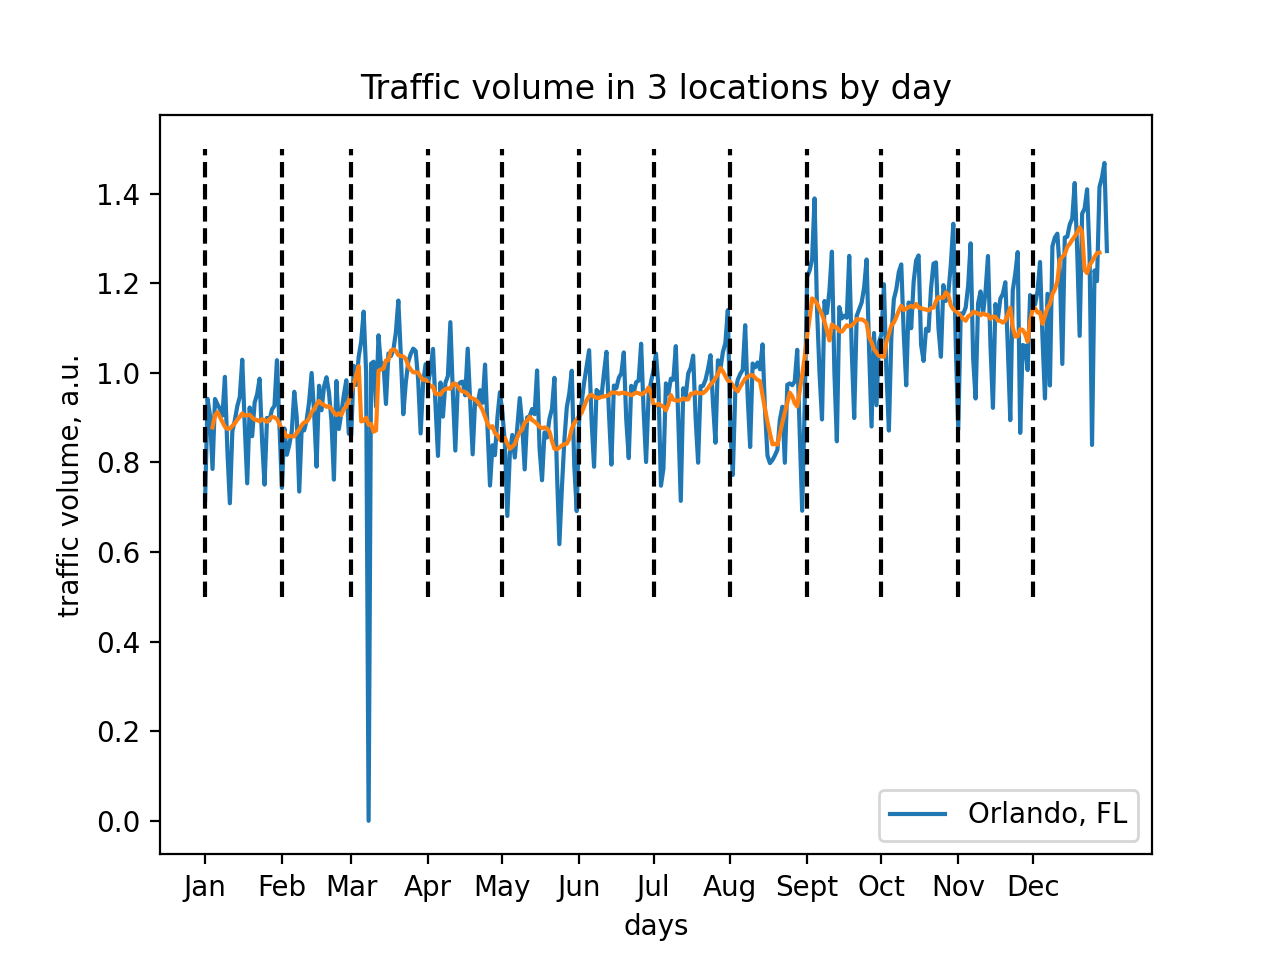

Text(0.5, 1.0, 'Traffic volume in 3 locations by day')

In [14]:
#
# Orlando, FL
#
lat_north = 28.8
lat_south = 27.7
long_west = 81.7 
long_east = 80.7

orlando_volume_1 = np.convolve(orlando_volume, np.ones((7,))/7, mode='valid')
days_1 = np.convolve(range(365), np.ones((7,))/7, mode='valid')
plt.plot(range(365), orlando_volume/np.mean(orlando_volume), label="Orlando, FL")
plt.plot(days_1, orlando_volume_1/np.mean(orlando_volume_1))


for i in months:
    plt.plot([i,i], [0.5, 1.5], color = "black", linestyle="dashed")

plt.xticks(months, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.xlabel("days")
plt.ylabel("traffic volume, a.u.")
plt.legend(loc="lower right")
plt.title("Traffic volume in 3 locations by day")